In [1]:
from numba import cuda, float32
import numba
import numpy as np
import math
import time
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
threads_per_block_xy = (25,25)

## A and B matrix mutliplication using CUDA 

In [4]:
@cuda.jit()
def matmul_gpu(A, B, C):
    row, col = cuda.grid(2)
    if row < C.shape[0] and col < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[row, k] * B[k, col]
        C[row, col] = tmp

In [5]:
timelist = []
Nrange = range(1,10000,1000)

print("start processing in GPU")

for N in tqdm(Nrange):
    A = np.random.rand(N,N)
    B = np.random.rand(N,N)
    C = np.random.rand(A.shape[0], B.shape[1])
    A_global_mem = cuda.to_device(A)
    B_global_mem = cuda.to_device(B)
    
    C_global_mem = cuda.device_array((A.shape[0], B.shape[1]))
    
    

    blocks_per_grid_x = int(math.ceil(A.shape[0] / threads_per_block_xy[0]))
    blocks_per_grid_y = int(math.ceil(B.shape[1] / threads_per_block_xy[1]))
    blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)


    start_gpu = time.time()
    matmul_gpu[blocks_per_grid, threads_per_block_xy](A_global_mem, B_global_mem, C_global_mem)
    cuda.synchronize()
    end_gpu = time.time()
    time_gpu = end_gpu - start_gpu
    timelist.append(time_gpu)
    C_global_gpu = C_global_mem.copy_to_host()

start processing in GPU


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [05:28<00:00, 32.87s/it]


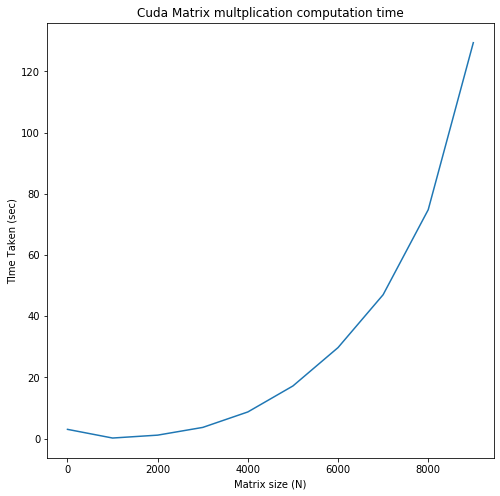

<Figure size 432x288 with 0 Axes>

In [6]:
fig = plt.figure(figsize=(8,8))
plt.plot(Nrange,timelist)
plt.xlabel('Matrix size (N)')
plt.ylabel('TIme Taken (sec)')
plt.title("Cuda Matrix multplication computation time")
plt.show()
plt.savefig("CUDATime_N.png")